In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle
from collections import Counter
import math


In [30]:
data_paths = {  'monday' : '../verisetleri/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv',
                'friday' : '../verisetleri/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
                 }

dataset_dict = {}

In [31]:
def upload_dataset_with_time(path:str):
    startingT = time.perf_counter()
    if 'pkl' in path:
        veriseti = pd.read_pickle(path)
    else:
        veriseti = pd.read_csv(path, low_memory=False)
    endingT = time.perf_counter()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

In [32]:
for data_name, path in data_paths.items():
    data = upload_dataset_with_time(path)
    dataset_dict[data_name] = data

Dataset is loaded in 5.331821999999988 seconds
Dataset is loaded in 1.959925300000009 seconds


In [33]:
dataset_dict["monday"]["Label"] = dataset_dict["monday"][" Label"].apply(lambda x: 0 if x == 'BENIGN' else 1)
dataset_dict["monday"].drop([" Label"], axis = 1, inplace = True)

In [34]:
monday_data = dataset_dict["monday"].groupby(" Timestamp").sum(numeric_only=True).reset_index(drop=False).copy()

In [41]:
dataset_dict["friday"]["Label"] = dataset_dict["friday"][" Label"].apply(lambda x: 0 if x == 'BENIGN' else 1)
dataset_dict["friday"].drop([" Label"], axis = 1, inplace = True)

In [74]:
friday_data = dataset_dict["friday"].groupby(" Timestamp").sum(numeric_only=True).reset_index(drop=False).copy()

In [75]:
friday_data.Label = friday_data.Label.apply(lambda x: 1 if x > 0 else 0)

In [76]:
drop_list = [ ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
       ' Bwd Avg Packets/Bulk',' Subflow Fwd Bytes',
        ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean',
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min', 'SimillarHTTP', ' Inbound', 'Unnamed: 0', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
        'Flow ID', ' Label']

col_drops = []
for col in drop_list:
    if col in friday_data.columns.to_list():
        col_drops.append(col)  

In [83]:
friday_data = friday_data.drop(col_drops, axis = 1)
monday_data = monday_data.drop(col_drops, axis = 1)

In [92]:
def plot_ddos(df: pd.DataFrame, attack_list:list[tuple]):
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='lightgreen', lw=3),
                    Line2D([0], [0], color='red', lw=3),
                    Line2D([0], [0], color='blue', lw=3),
                    Line2D([0], [0], color='black', lw=3),
                    Line2D([0], [0], color='brown', lw=3)]
    
    attack_color_dict = {'syn' : 'lightgreen', 'ntp' : 'red', 'udp' : 'blue', 'udp_lag' : 'black', 'ldap' : 'brown'}
    
    total_duration = len(df)
    print(f"Total Duration Of Traffic is: {total_duration} minutes")
    xAxis = list(range(len(df)))
    #yAxis = df["Label"].to_list()
    import numpy
    yAxis = list(np.zeros(len(df)))
    fig = plt.figure(figsize=(25,15))
    ax = fig.add_subplot()
    ax.plot(xAxis, yAxis)
    
    legend_custom_lines = []
    legend_custom_names = []
    for attack in attack_list:
        face_color = attack_color_dict[attack[0]]
        attack_duration = attack[1]
        duration_before_attack = attack[2]
        
        attack_index = list(attack_color_dict.keys()).index(attack[0])
        if attack[0] not in legend_custom_names:
            legend_custom_lines.append(custom_lines[attack_index])
            legend_custom_names.append(attack[0])
        
        rect = Rectangle((duration_before_attack, 0), attack_duration, 1, facecolor=face_color)
        ax.add_patch(rect)

    
    ax.legend(legend_custom_lines, legend_custom_names,  prop={'size': 20})
    
    plt.ylabel('Label')
    plt.xlabel('Seconds')
    plt.title('Network Traffic')
    plt.show()

In [93]:
ddos_data = friday_data[friday_data.Label == 1].reset_index(drop=True)
friday_benign = friday_data[friday_data.Label != 1].reset_index(drop=True)

In [122]:
network_traffic_dataset = pd.concat([monday_data.iloc[:10], monday_data.sample(20),
                                     ddos_data.iloc[:3],
                                     friday_benign.iloc[:5],
                                     ddos_data.iloc[:2],
                                     friday_benign.iloc[:5], friday_benign.sample(15)], axis = 0).reset_index(drop=True)

Total Duration Of Traffic is: 60 minutes


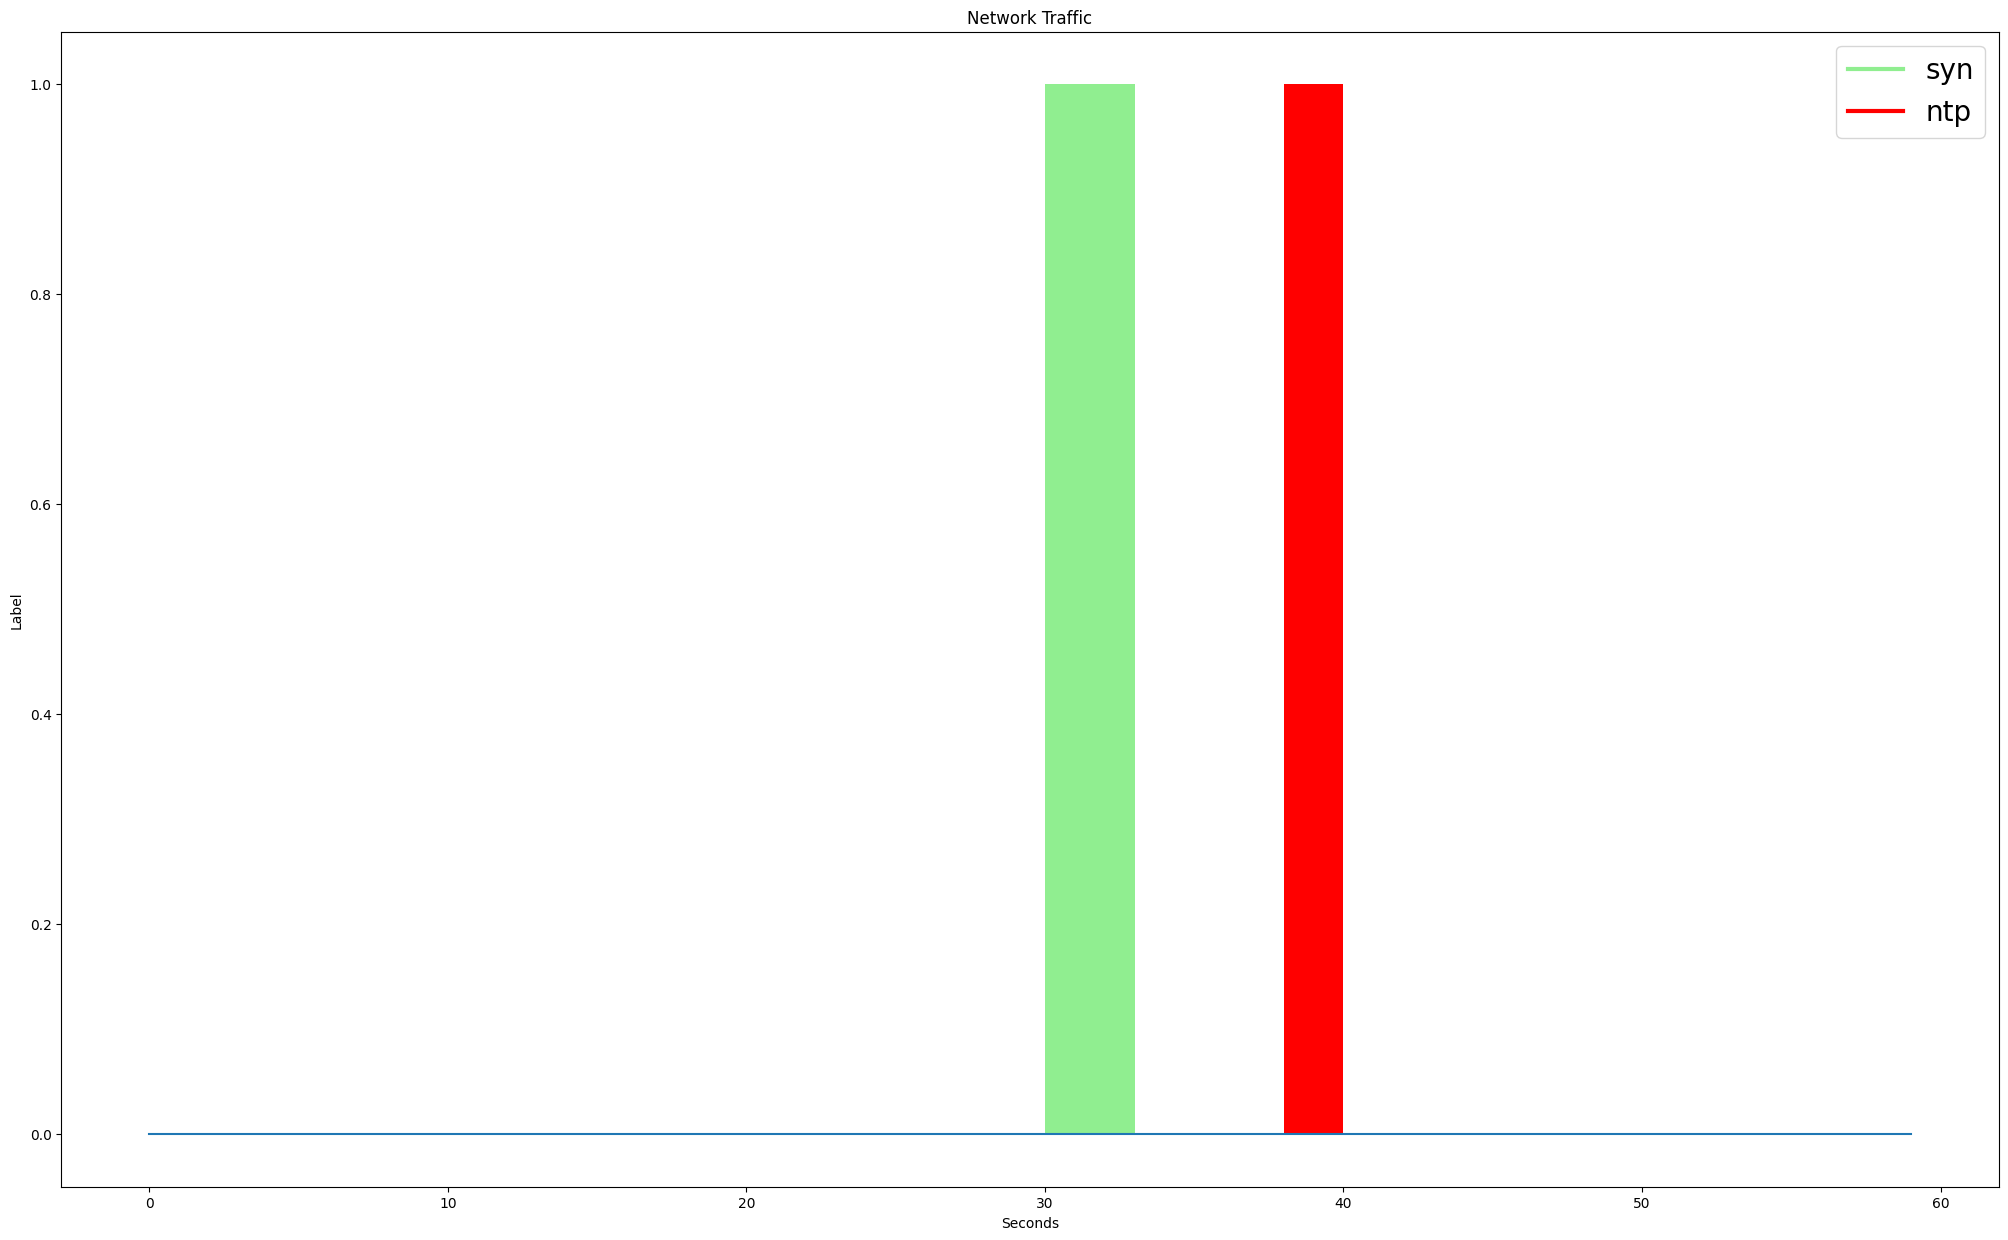

In [123]:
plot_ddos(network_traffic_dataset, attack_list=[('syn', 3, 30), ('ntp', 2, 38)])

In [125]:
from mp_utils import *
import warnings
warnings.filterwarnings('ignore')

In [126]:
f1_score_list = []
MatrixProfileManager.global_df = network_traffic_dataset.copy()
for col in network_traffic_dataset.columns[:-1]:
    threshold_MP_syn = ThresholdMatrixProfile(pd.DataFrame(network_traffic_dataset[col]), window_size=5, threshold=2)
    cost, f1_score = threshold_MP_syn.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.27777777777777773, 'Flow Bytes/s'),
 (0.27777777777777773, ' Flow Packets/s'),
 (0.15625, ' Bwd PSH Flags'),
 (0.15625, ' Fwd URG Flags'),
 (0.15625, ' Bwd URG Flags')]

In [127]:
f1_score_list = []
for col in network_traffic_dataset.columns[:-1]:
    isolation_MP_syn = IsolationMatrixProfile(pd.DataFrame(network_traffic_dataset[col])
                                              , window_size=5, n_estimators = 100, contamination='auto')
    cost, f1_score = isolation_MP_syn.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]

[(0.47058823529411764, 'Fwd PSH Flags'),
 (0.4444444444444444, ' SYN Flag Count'),
 (0.32000000000000006, ' Total Backward Packets'),
 (0.32000000000000006, 'Total Length of Fwd Packets'),
 (0.29411764705882354, ' Flow IAT Mean')]

In [128]:
from GeneticAlgorithmWrapper import *
from time import perf_counter

start_time = perf_counter()

MatrixProfileManager.global_df = network_traffic_dataset.copy()
GA = GeneticAlgo(network_traffic_dataset.copy(), max_features=30, population_bag_size=10,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.IsolationForest,  window_size=5)


pop_bag = GA.initialize_population()
generation_number = 500

import random
f1_score_list = []
for generation in range(generation_number):
    if (generation % 50 == 0):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        f1_score_list.append(best_f1_score)
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution
                print(f"best f1: {best_f1_global}")

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.70:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {max(f1_score_list)}")

end_time = perf_counter()
print(f"simulation longs {end_time - start_time} seconds")

Genetic Algorithm Process is ready to start
Generation 0 is started!
Generation 50 is started!
best f1: 0.19999999999999998
Generation 100 is started!
best f1: 0.25
Generation 150 is started!
best f1: 0.25806451612903225
Generation 200 is started!
Generation 250 is started!
Generation 300 is started!
Generation 350 is started!
Generation 400 is started!
Generation 450 is started!
best f1: 0.32000000000000006


**** Generations Over ****

Best Fitness: 0
Best Solution: [6, 26, 1, 20, 23, 3, 7]
F1-Score: 0.32000000000000006
simulation longs 16.0643728 seconds


In [110]:
GA = GeneticAlgo(network_traffic_dataset.copy(), max_features=30, population_bag_size=10,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.ThresholdBase,  window_size=10)

MatrixProfileManager.global_df = network_traffic_dataset
pop_bag = GA.initialize_population()
generation_number = 1000
f1_score_list = []

import random
for generation in range(generation_number):
    if (generation % 50 == 0):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        f1_score_list.append(best_f1_score)
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.87:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {max(f1_score_list)}")

Genetic Algorithm Process is ready to start
Generation 0 is started!
Generation 50 is started!
Generation 100 is started!
Generation 150 is started!
Generation 200 is started!
Generation 250 is started!
Generation 300 is started!
Generation 350 is started!
Generation 400 is started!
Generation 450 is started!
Generation 500 is started!
Generation 550 is started!
Generation 600 is started!
Generation 650 is started!
Generation 700 is started!
Generation 750 is started!
Generation 800 is started!
Generation 850 is started!
Generation 900 is started!
Generation 950 is started!


**** Generations Over ****

Best Fitness: 0
Best Solution: [17, 19, 3, 0]
F1-Score: 0.30303030303030304
